# Tensorflow 실습 : RNN을 이용한 텍스트 분류

- 학습 속도를 위해, GPU를 사용하기를 권장

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# history를 그래프로 그리기 위해 사용
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## IMDB 데이터셋 

### Setup input pipeline

- IMDB (Internet Movie Database)는 영화 리뷰를 모아 놓은 데이터셋으로, 각 리뷰가 긍정적인지 부정적인지 label이 되어 있음
- 따라서 어떤 리뷰가 긍정/부정적인지 분류하는 binary classification 문제를 학습하기 위해 많이 사용됨
- 또한, text는 대표적인 sequencial data이므로, RNN을 사용해보기에 적합함
- tfds (tensorflow_datasets)를 통해 간단히 load 및 전처리하여 사용 가능

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2F5J5K/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2F5J5K/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete2F5J5K/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


- 데이터셋의 `info`는 encoder를 가지고 있음 (`tfds.features.text.SubwordTextEncoder`)

In [ ]:
encoder = info.features['text'].encoder
# 전체 단어의 가지수는 8185
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


- **encoder**를 이용하면, **영어 문장을 숫자로 표현하고, 숫자를 다시 문장으로 복원**하는 것이 가능함
  - encode: 영어 문장 => 정수(integer)의 sequence
  - decode: 정수(integer)의 sequence => 영어 문장

In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [ ]:
# 원래 문장과 encode-decode 과정을 통과한 문장은 항상 동일함
assert original_string == sample_string

In [ ]:
# 정수 하나와 단어 하나가 매치된 것을 확인할 수 있음
# 완전히 단어 1개 단위로 나뉜 것은 아니고, 음절 단위로 나누는 방식을 활용하는 것으로 보임
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### 참고
- text를 token(정수, integer) 단위로 표현하는 방식은 다양함
- text를 token 단위로 나누어주는 메소드를 Tokenizer라고 함
  - 영어에서 알파벳 하나씩 token 단위로 변환하는 방법 (character level)
  - 음절 단위로 변환
  - 단어 단위로 변환 (word level)
- 한국어 문장을 이용하기 위해서는 한국어 전용 Tokenizer가 필요함

### 학습을 위한 데이터셋 준비

In [ ]:
num_train = len(list(train_dataset))
num_test = len(list(test_dataset))

print('학습 데이터 수: ', num_train)
print('테스트 데이터 수: ', num_test)

BUFFER_SIZE = 10000 #1 epoch이 되는 데이터 수
BATCH_SIZE = 64 #1 step에서 사용되는 데이터 수

학습 데이터 수:  79
테스트 데이터 수:  196


- 테스트 데이터셋은 반으로 나누어서 validation 데이터셋과 테스트 데이터셋으로 사용
  - take: 앞에서부터 인자로 받은 숫자까지의 데이터만 사용
  - skip: 인자로 받은 숫자부터 끝까지 데이터를 사용

In [ ]:
valid_dataset = test_dataset.take(num_test // 2)
test_dataset = test_dataset.skip(num_test // 2)

# 학습 시간이 오래걸리므로 학습 데이터를 1/5 만 사용
# 모델의 좋은 성능을 위해서는 학습 데이터를 모두 사용하는 것이 정상적임
train_dataset = train_dataset.take(num_train // 5)

- (중요) 각 리뷰 문장은 token의 개수가 정해져 있는 것이 아니므로, 전체 sequence 길이가 각각 다름
- 따라서 mini batch 안에서 가장 길이가 긴 sequence 길이에 맞도록, 나머지 문장들에 padding token을 추가해줘야 함
  - dataset에서 batch 대신 `padded_batch`를 사용

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

valid_dataset = valid_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

- mini batch load 결과 확인
  - x는 리뷰 데이터, shape는 [batch size, sequence 길이], 가장 길이가 긴 sequence에 맞추어 나머지 문장에는 padding (0)으로 채워짐
  - y는 각 리뷰에 대한 긍정(1), 부정(0) label

In [ ]:
for x, y in train_dataset.take(1):
  print(x)
  print(y)

tf.Tensor(
[[ 404  335   12 ...    0    0    0]
 [  12   18 1866 ...    0    0    0]
 [  12   56  207 ...    0    0    0]
 ...
 [ 147 1372 7980 ...    0    0    0]
 [ 133 4330 7998 ...    0    0    0]
 [  12 2129   22 ...    0    0    0]], shape=(64, 914), dtype=int64)
tf.Tensor(
[0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0
 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1], shape=(64,), dtype=int64)


## RNN 모델을 이용한 텍스트 분류

### RNN 모델
- Embedding layer (학습 가능한 파라미터)
  - 정수(integer)를 vector로 mapping하는 방법을 embedding이라고 함
  - 쉽게 이해하자면, 정수 => one-hot vector => W matrix를 곱해주는 것과 동일함 (activation, bias가 없는 Dense layer)
- `tf.keras.layers.Embedding` 사용법
  - input_dim : 전체 vocabulary의 사이즈
  - output_dim : output 벡터의 차원
  - mask_zero : True로 하면, 0의 값(padding)은 mask로 가려지게 됨 
- masking의 의미 : paddding 부분은 RNN 모델에 input으로 사용되지 않고, padding이 아닌부분만 가지고 RNN의 output을 계산함

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=64, mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


### 옵티마이저(optimizer), 손실 함수, 평가 metric 선택

In [ ]:
# Binary classification에 적합한 loss를 선정, 마지막 dense layer에 sigmoid activation이 없으므로 from_logits=True
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

###모델 학습


In [ ]:
# 한 epoch에 걸리는 시간을 줄이기 위해, validation step을 30으로 제한
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    validation_steps=30)

Epoch 1/10
79/79 [==============================] - 28s 232ms/step - loss: 0.6929 - accuracy: 0.4948 - val_loss: 0.6926 - val_accuracy: 0.4917
Epoch 2/10
79/79 [==============================] - 17s 212ms/step - loss: 0.6913 - accuracy: 0.4948 - val_loss: 0.6904 - val_accuracy: 0.4917
Epoch 3/10
79/79 [==============================] - 16s 203ms/step - loss: 0.6517 - accuracy: 0.5424 - val_loss: 0.7346 - val_accuracy: 0.5536
Epoch 4/10
79/79 [==============================] - 17s 207ms/step - loss: 0.5991 - accuracy: 0.6310 - val_loss: 0.6662 - val_accuracy: 0.5568
Epoch 5/10
79/79 [==============================] - 16s 202ms/step - loss: 0.5239 - accuracy: 0.7348 - val_loss: 0.5641 - val_accuracy: 0.7385
Epoch 6/10
79/79 [==============================] - 16s 200ms/step - loss: 0.4261 - accuracy: 0.8318 - val_loss: 0.4894 - val_accuracy: 0.7661
Epoch 7/10
79/79 [==============================] - 16s 202ms/step - loss: 0.3453 - accuracy: 0.8788 - val_loss: 0.4845 - val_accuracy: 0.7839

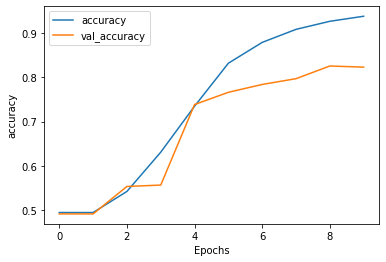

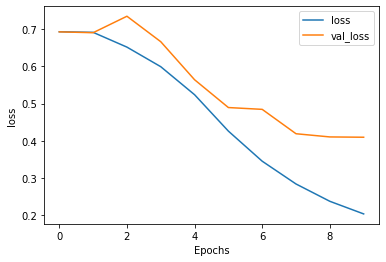

In [ ]:
# 그래프 그리기
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### 모델 평가

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

196/196 [==============================] - 15s 73ms/step - loss: 0.3864 - accuracy: 0.8312
Test Loss: 0.3863837420940399
Test Accuracy: 0.8312000036239624


### 학습된 모델 활용

In [ ]:
# predict on a sample text
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.'

# 정수(integer) sequence로 encode
sample_input = encoder.encode(sample_text)

# 모델의 input으로 넣어주기 위해, batch 축 추가
sample_input = tf.expand_dims(sample_input, axis=0)

# 학습된 모델로 긍정/부정 예측
prediction = model(sample_input)

# 마지막 sigmoid activation이 없으므로, output logit 값이 양수이면 긍정적, 음수이면 부정적임을 의미함
print(prediction)


tf.Tensor([[0.17174675]], shape=(1, 1), dtype=float32)


- 다음 문제 실습을 위해, 학습된 모델 삭제

In [ ]:
del model

## RNN 실습
데이터셋은 그대로 이용하고 나머지 부분을 직접 구현해보기

### 문제 1: RNN 모델 만들기
- 조건: 딥러닝 모델의 각 layer는 1번부터 8번까지 순서대로 구성
1. embedding layer, input_dim: vocab size, output_dim: 128, mask zero: True
2. bidirectional, GRU layer, hidden units 64 (Hint: RNN layer를 여러개 쌓는 상황을 고려해야 함)
3. layer normalization
4. GRU layer, hidden units 32
5. layer normalization
6. dropout layer, probability 0.2
7. dense layer, hidden node 32, ReLU activation
8. dense layer, hidden node 1
- 딥러닝 모델을 만드는 두가지 방식(tf.keras.Model, tf.keras.models.Sequential) 중 선택하여 만들기

In [ ]:
# 여기에 문제 1에 대한 코드를 작성하면 됩니다.

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(32),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         1047680   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         74496     
_________________________________________________________________
layer_normalization_4 (Layer (None, None, 128)         256       
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                15552     
_________________________________________________________________
layer_normalization_5 (Layer (None, 32)                64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

### 문제 2: 옵티마이저(optimizer), 손실 함수, 평가 metric 선택
- 조건1: model.compile로 지정
- 조건2: binary classification에 적합한 loss 선택, from logits: True
- 조건3: Adam optimizer, learning rate: 0.001
- 조건4: metric은 accuracy

In [ ]:
# 여기에 문제 2에 대한 코드를 작성하면 됩니다.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

### 문제 3: 모델 학습 및 평가
- 조건1: model.fit으로 학습
- 조건2: 5 epoch 동안 학습
- 조건3: 학습 데이터로 `train_dataset` 이용
- 조건4: `valid_dataset`으로 validation, 매번 epoch 당 validation step은 20번
- 조건5: 학습이 완료된 모델을 이용하여, `test_dataset`으로 모델 평가

In [ ]:
# 여기에 문제 3에 대한 코드를 작성하면 됩니다.
history = model.fit(train_dataset, epochs=5,
                    validation_data=valid_dataset,
                    validation_steps=20)

Epoch 1/5
79/79 [==============================] - 59s 599ms/step - loss: 0.6940 - accuracy: 0.5300 - val_loss: 0.6346 - val_accuracy: 0.5922
Epoch 2/5
79/79 [==============================] - 42s 535ms/step - loss: 0.4663 - accuracy: 0.7752 - val_loss: 0.6091 - val_accuracy: 0.6711
Epoch 3/5
79/79 [==============================] - 42s 533ms/step - loss: 0.1968 - accuracy: 0.9262 - val_loss: 0.7890 - val_accuracy: 0.6797
Epoch 4/5
79/79 [==============================] - 43s 536ms/step - loss: 0.0756 - accuracy: 0.9768 - val_loss: 1.2057 - val_accuracy: 0.6938
Epoch 5/5
79/79 [==============================] - 42s 535ms/step - loss: 0.0449 - accuracy: 0.9866 - val_loss: 1.2427 - val_accuracy: 0.7047


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

196/196 [==============================] - 47s 233ms/step - loss: 1.1692 - accuracy: 0.7130
Test Loss: 1.1691505908966064
Test Accuracy: 0.7129600048065186


### 문제 4: 학습된 모델 활용

- 가상의 리뷰를 직접 작성하여 모델의 input으로 넣어보기
- 조건: 긍적적인 리뷰 1개와 부정적인 리뷰 1개를 작성하여, 모델의 예측값을 확인해보기

In [ ]:
# 여기에 문제 4에 대한 코드를 작성하면 됩니다.
#긍정리뷰
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie. good good good'
sample_input = encoder.encode(sample_text)
sample_input = tf.expand_dims(sample_input, axis=0) #expand_dims: axis로 지정된 차원을 추가
prediction = model(sample_input)
print(prediction)

tf.Tensor([[5.5086513]], shape=(1, 1), dtype=float32)


In [ ]:
#부정리뷰
sample_text = 'This movie is ambiguous. There was also an interesting part, but most of the time was boring. bad bad bad'
sample_input = encoder.encode(sample_text)
sample_input = tf.expand_dims(sample_input, axis=0)
prediction = model(sample_input)
print(prediction)

tf.Tensor([[-5.7782073]], shape=(1, 1), dtype=float32)


- (참고) 학습 데이터를 많이 사용하면, 오버피팅이 어느정도 해결되고 더 나은 성능을 보인다는 것을 확인할 수 있음